In [18]:
import matplotlib
import cv2 as cv
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [19]:
def load_images_as_array(file_paths):

    # Initialize an empty list to store individual image arrays
    images_list = []

    # Loop through each file path and load the image
    for file_path in file_paths:
        try:
            # Open the image using PIL
            img = Image.open(file_path)

            # Convert the image to a NumPy array
            img_array = np.array(img)

            # Append the array to the list
            images_list.append(img_array)
        except Exception as e:
            print(f"Error loading image at {file_path}: {e}")

    return images_list

# Example usage:
file_paths = ["./images/crack1.jpg", "./images/crack2.jpeg", "./images/crack3.jpg"]
loaded_images = load_images_as_array(file_paths)

def convert_to_cv2(np_img): 
    cv2_image = cv.cvtColor(np_img, cv2.IMREAD_GRAYSCALE)
    return cv2_image

# Image processing methods

Hough transform in OpenCV: https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
Find curves on the image: https://pushkin.faculty.unlv.edu/ece5554/lecture7.pdf
Lines and curves detection: https://sites.ecse.rpi.edu/~qji/CV/HTX.pdf
Lines and curves detection: https://homepages.inf.ed.ac.uk/rbf/BOOKS/BANDB/LIB/bandb4_3.pdf




In [140]:
def blur_image(image, kernel_size=(5, 5)):
    blurred_image = cv.GaussianBlur(image, kernel_size, 0)
    return blurred_image

def img_proc(img, show=True):
    img = cv.imread(img, cv.IMREAD_GRAYSCALE)
    # Blur image 
    blur_xk = 21
    img = blur_image(img, (blur_xk, blur_xk))
    # Canny edge detection
    canny_min = 50; canny_max = 100; 
    edges = cv.Canny(img, 50, 100)
    # Plot images
    if show: 
        plt.figure(figsize=(15, 10))
        plt.subplot(121),plt.imshow(img,cmap = 'gray')
        plt.title('Original Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(edges,cmap = 'gray')
        plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
        plt.show()
    return edges

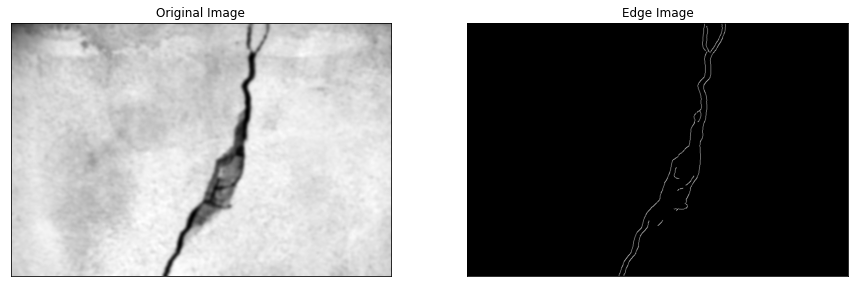

In [141]:
edge1 = img_proc(file_paths[0], show=True)
edge2 = img_proc(file_paths[1], show=False)
edge3 = img_proc(file_paths[2], show=False)

In [361]:
def show_img(img): 
    plt.imshow(img,cmap = 'gray')
    plt.title('Original Image')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    
def show_imgs(edges, pts): 
    # Create a figure and axis
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    # Plot the first horizontal subplot
    ax1.imshow(edges, cmap='gray')
    ax1.set_title('Edges image')

    # Plot the second horizontal subplot
    ax2.scatter(pts[:, 0], pts[:, 1], color='green')
    #ax2.set_xlim([0, 1000]); ax2.set_ylim([0, 600])

    # Set common labels and show the figure
    plt.tight_layout()  # Adjust layout to prevent clipping of titles
    plt.show()

def hough_lines(edges, dividor, show=False): 
    num_votes = int(min(edges.shape)/dividor)
    lines = cv2.HoughLines(edges,1,np.pi/180, num_votes)
    print(f"Number of detected lines for {num_votes} votes is: {len(lines)}")
    for line in lines[:1]: 
        print(line)
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(edges,(x1,y1),(x2,y2),(255,255,255), 2)
    
    if show: 
        show_img(edges)

    return lines

# THIS IS GOOD ONE [GIVES POINTS!]
# EXTRACT THOSE POINTS AND PREFORM POLYNOMIAL REGRESSION TO FIND PATH [CHECK DURATION]
def hough_lines_p(edges, dividor, show): 
    num_votes = int(min(edges.shape)/dividor)
    minLineLength = 30; maxLineGap = 5
    lines = cv2.HoughLinesP(edges,cv2.HOUGH_PROBABILISTIC, np.pi/180, num_votes, minLineLength, maxLineGap)
    print(f"Number of detected lines for {num_votes} votes is: {len(lines)}")
    pts_ = None
    for x in range(0, len(lines)):
        for x1,y1,x2,y2 in lines[x]:
            p1 = np.array([x1, y1]); p2 = np.array([x2, y2])
            if x == 0:
                pts_ = np.vstack((p1, p2))
            else: 
                pts_ = np.vstack((pts_, p1, p2))
            #cv2.line(inputImage,(x1,y1),(x2,y2),(0,128,0),2, cv2.LINE_AA)
            pts = np.array([[x1, y1 ], [x2 , y2]], np.int32)
            cv2.polylines(edges, [pts], True, (255,255,255), 3)
    if show: 
        show_imgs(edges, pts_)
        
    return pts_


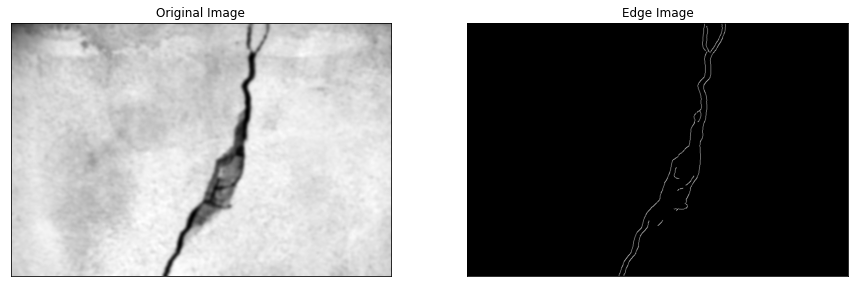

Number of detected lines for 21 votes is: 51


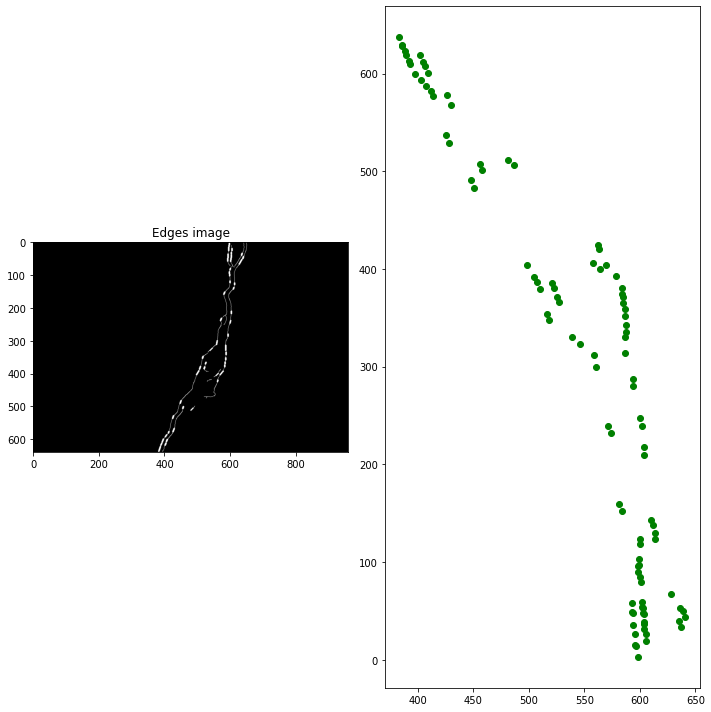

In [420]:
edge1 = img_proc(file_paths[0], show=True)
d_ = 30
pts1 = hough_lines_p(edge1, d_, True)

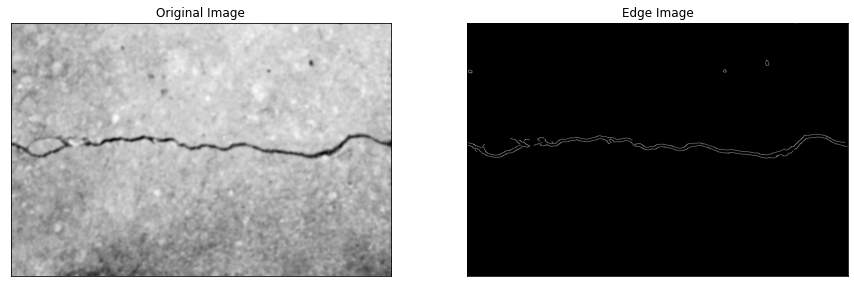

Number of detected lines for 80 votes is: 16


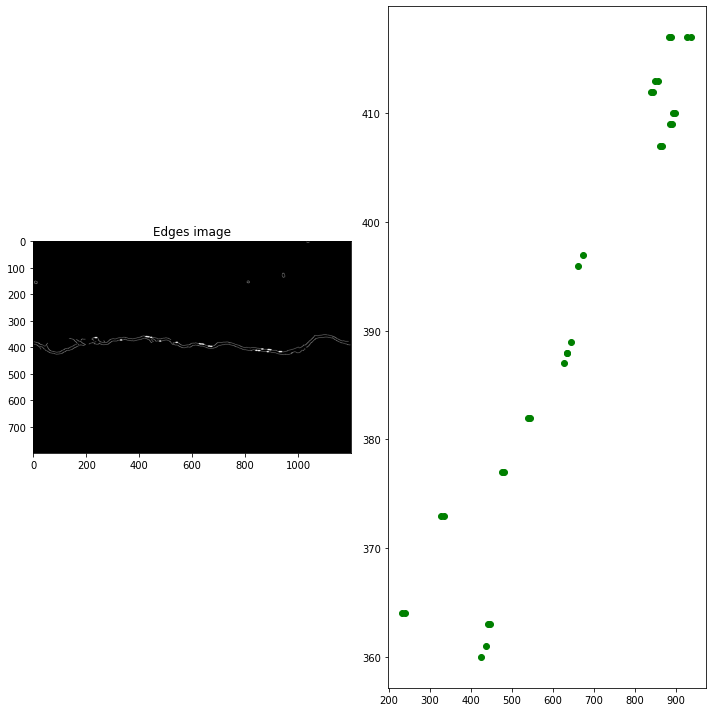

In [421]:
d_ = 10
edge2 = img_proc(file_paths[1])
pts2 = hough_lines_p(edge2, d_, True)

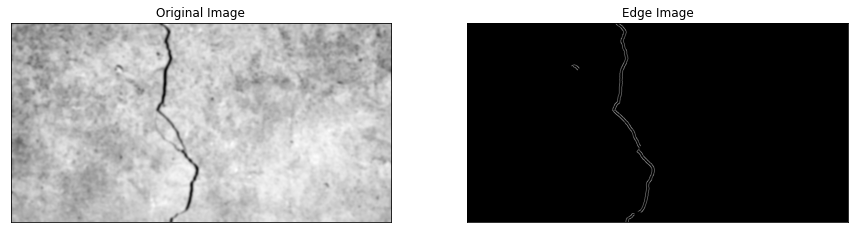

Number of detected lines for 21 votes is: 54


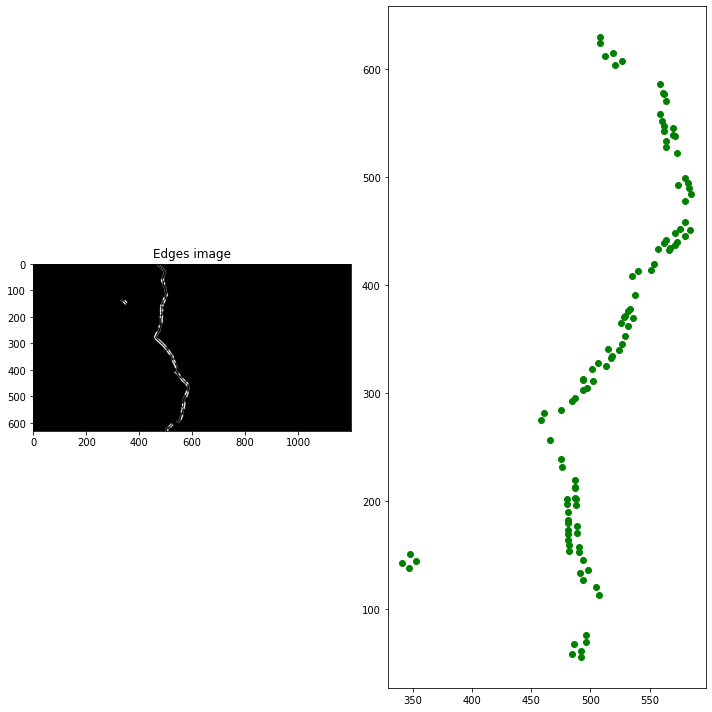

In [422]:
d_ = 30
edge3 = img_proc(file_paths[2])
pts3 = hough_lines_p(edge3, d_, True)

In [550]:
import time

def sortxy(pts):
    x = pts[:, 1]; y = pts[:, 0]
    # Create a list of tuples (value, index)
    sort_x = list(zip(x, range(len(x))))
    # Sort the list of tuples based on values
    sort_xix = sorted(sort_x, key=lambda x: x[0])
    # Unzip the sorted tuples
    x, ix = zip(*sort_xix)
    # Use the sorted indexes to reorder the other list
    sort_y = [y[i] for i in ix]
    return x, sort_y

def polynomial_fitting(pts, order): 
    start_time = time.time()
    # TODO: Speed up by sorting just one time :) 
    x, y = sortxy(pts)
    # Get polynomes
    p = np.polyfit(x, y, order); f = np.poly1d(p)
    x_new = np.linspace(min(x), max(x), num=len(list(x))); y_new = f(x_new)
    e = get_error(y, y_new)
    end_time = time.time()
    t = end_time - start_time
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y)
    plt.plot(x_new, y_new)
    plt.title(f"Poly of order {order} with error {round(e,1)}")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.grid()
    return y, y_new

def get_error(y, y_new): 
    return np.sqrt(np.sum((y-y_new)**2))

def fit_multiple_orders(pts, num_orders):
    orders = list(range(0, num_orders))
    start_t = time.time()
    for o in orders:
        y, y_new = polynomial_fitting(pts, o)
        check_error(y, y_new)
        end_t = time.time()

Error is: 800.3964765088882
Error is: 397.79264242162395
Error is: 256.54167763053425
Error is: 256.5798764759206
Error is: 254.32168611313472


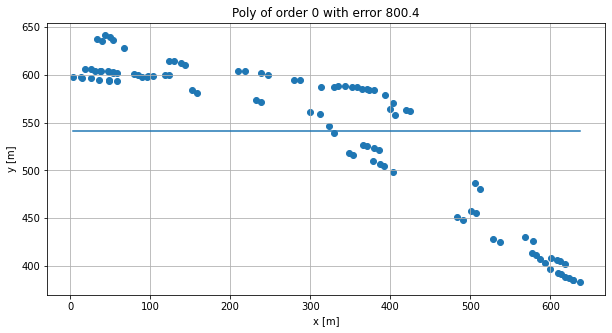

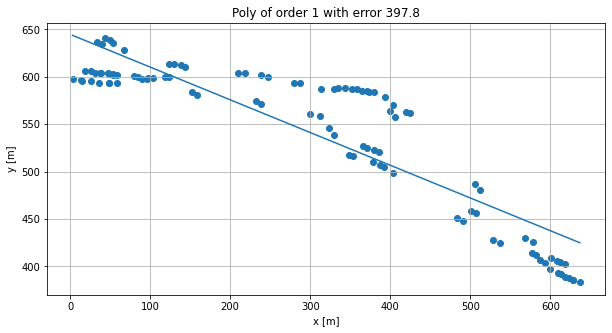

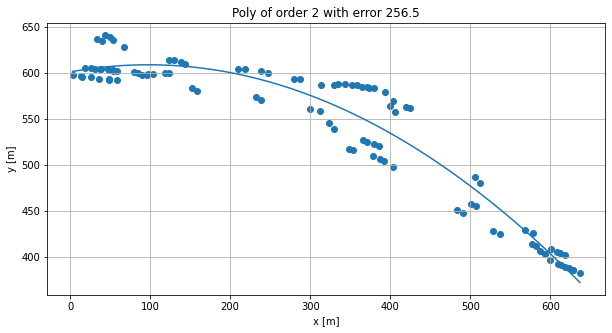

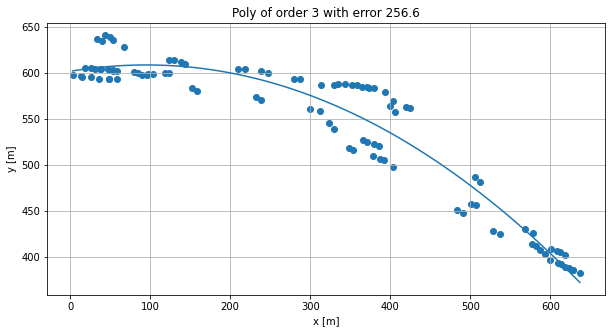

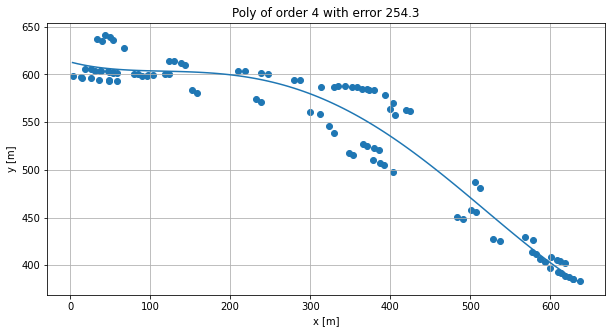

In [551]:
#polynomial_fitting(pts1, 2); polynomial_fitting(pts1, 3); polynomial_fitting(pts1, 4)
# 0.15 sekundi duration da prodje kroz X tocaka 
fit_multiple_orders(pts1, 5)

        

Error is: 1247.7795778902619
Error is: 558.6979625551627
Error is: 582.1670696964729
Error is: 483.3901509035541
Error is: 431.96575218324796
Error is: 487.87906994345633
Error is: 482.1911296118558
Error is: 536.958477693202
Error is: 527.7988221999825
Error is: 528.0546945585388


/tmp/ipykernel_67380/1219476776.py:41: RankWarning: Polyfit may be poorly conditioned
  y, y_new = polynomial_fitting(pts, o)


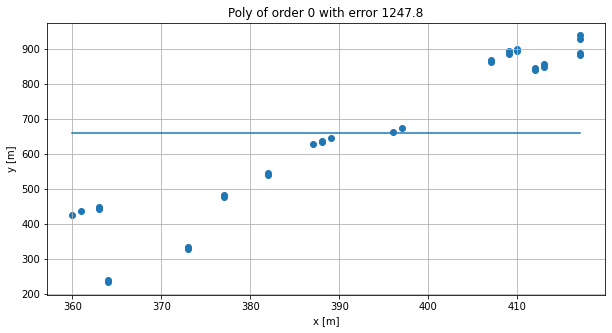

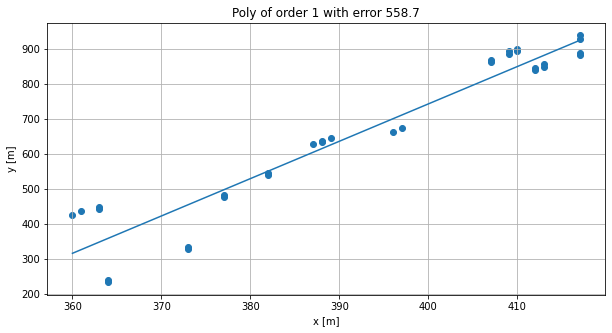

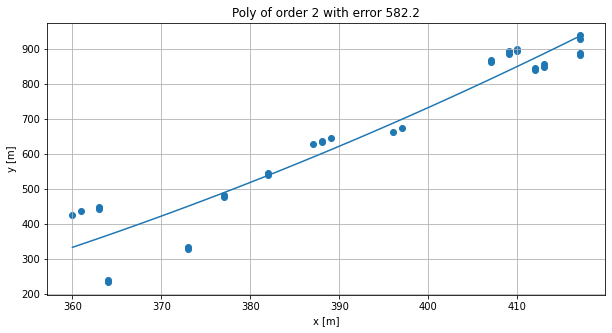

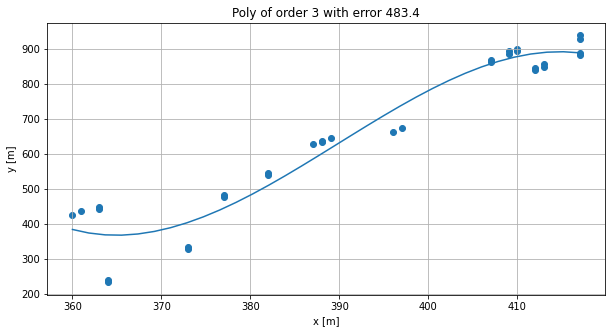

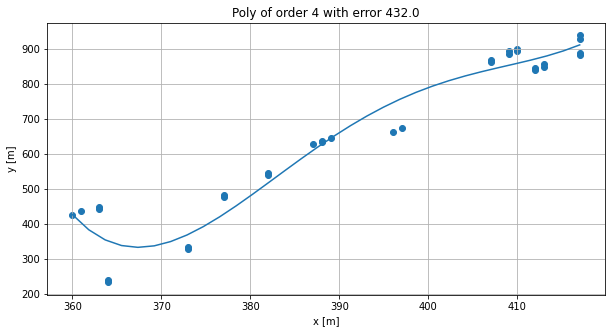

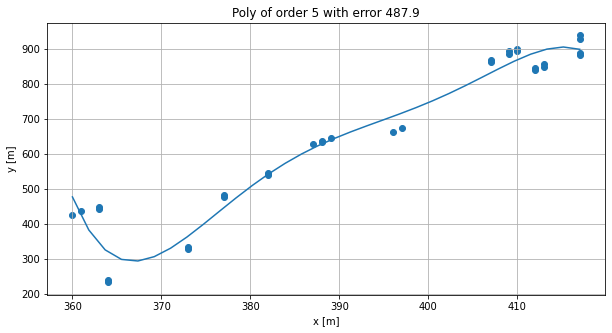

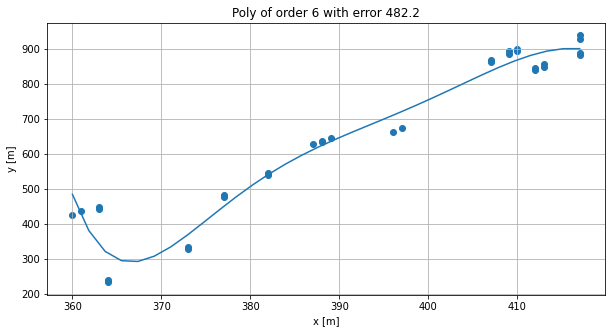

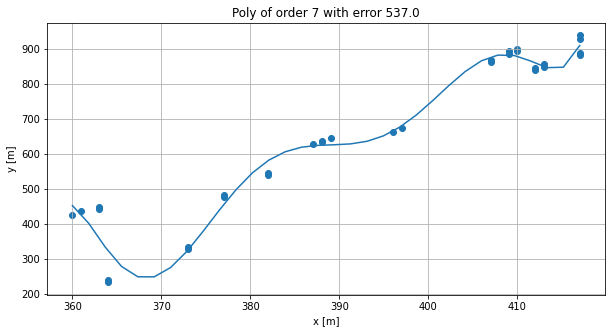

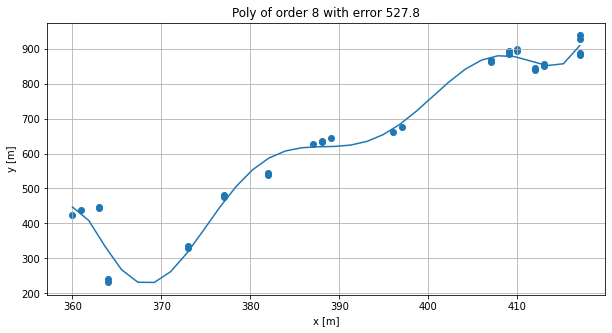

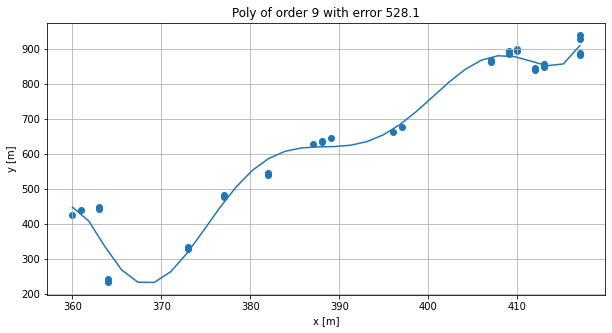

In [553]:
fit_multiple_orders(pts2, 10)

Error is: 509.3969928221959
Error is: 349.0317370987749
Error is: 346.1532693776482
Error is: 275.80310578137244
Error is: 273.72252789970975
Error is: 273.3011310914537
Error is: 267.48037152876384
Error is: 266.4964340828753
Error is: 264.5672567225924
Error is: 258.3727800645165


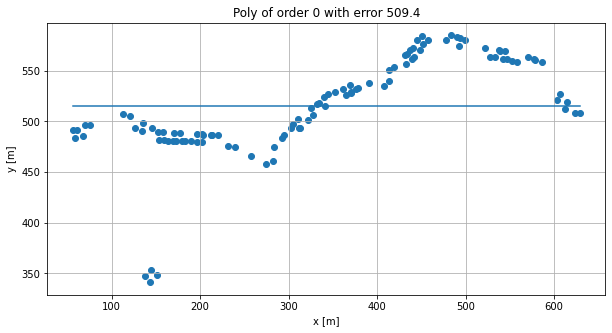

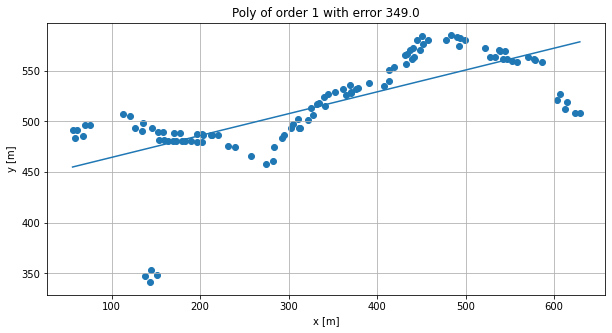

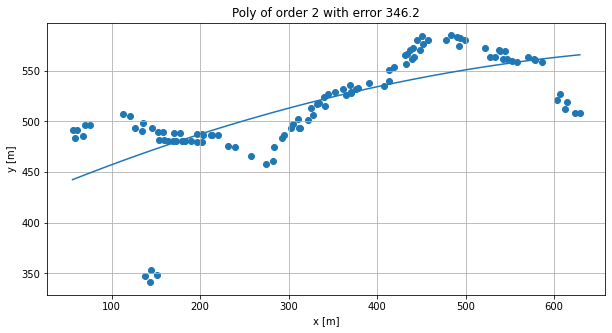

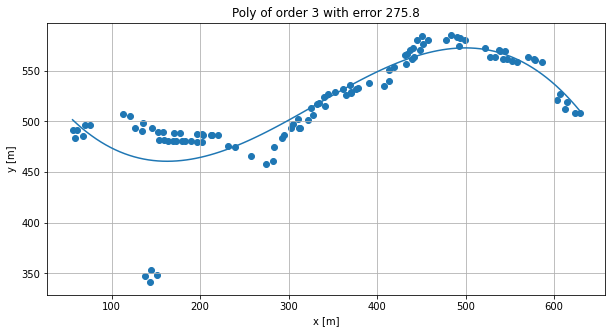

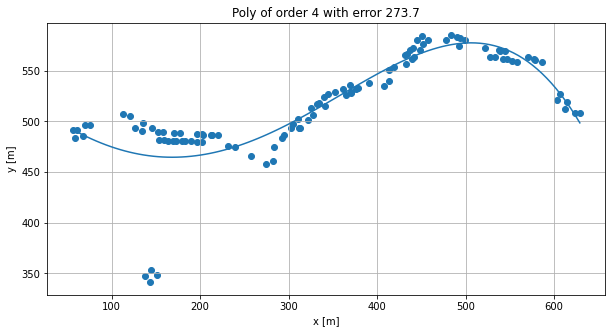

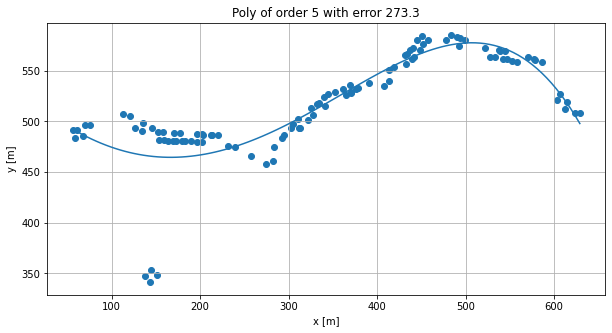

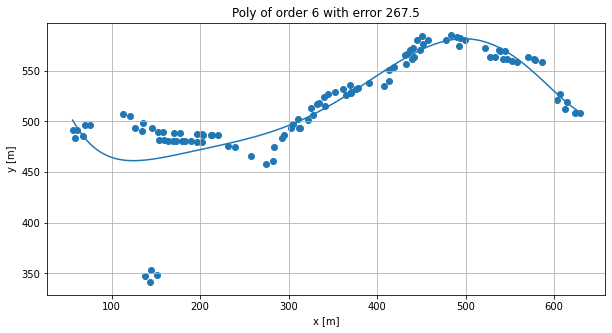

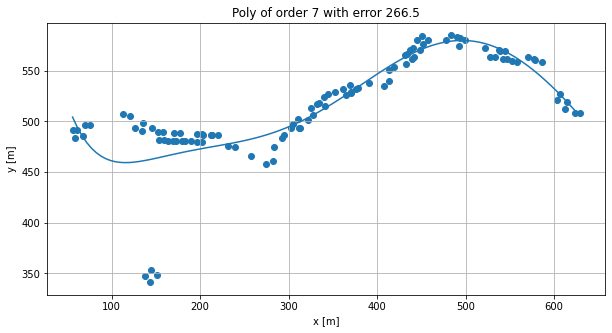

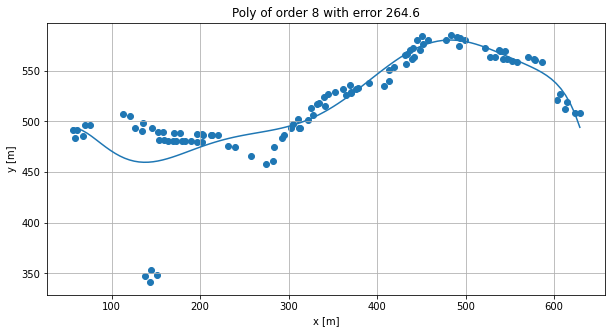

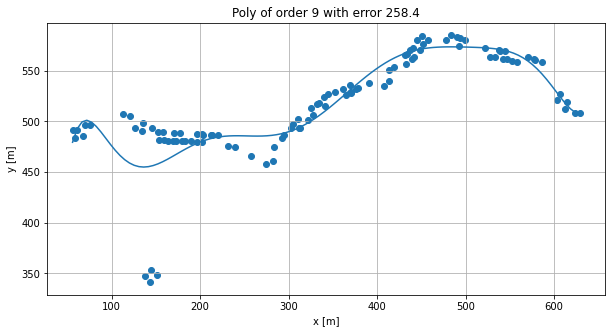

In [554]:
fit_multiple_orders(pts3, 10)

## TODO:

- [ ] Try ROS wrapper for the trajectory generation 
- [ ] Test on the real images and real trajectory generation data


In [3]:
import pandas as pd
import csv

In [51]:
def load_text_file(file_path):
    try:
        with open(file_path, 'r') as file:
            # Read all lines from the file and store them in a list
            lines = file.readlines()
            
            # Remove newline characters from each line
            lines = [line.strip() for line in lines]
            
            return lines
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage:
rtmdet_file_path = './rtmdet-s.txt'  # Replace with the actual path to your text file
rtmdet = load_text_file(rtmdet_file_path)
maskrcnn_file_path = './mask-rcnn-50.txt'
maskrcnn = load_text_file(maskrcnn_file_path)

print(rtmdet)
#print(maskrcnn)

['0.494365931', '0.173731804', '0.124452591', '0.132151842', '0.10625124', '0.109457255', '0.110750437', '0.115735531', '0.11881566', '0.144871474', '0.15096283', '0.141798496', '0.13306427', '0.134145498', '0.112680912', '0.110203504', '0.12336278', '0.154862166', '0.144143343', '0.138210535', '0.126764536', '0.162992', '0.139956713', '0.112037421', '0.14084959', '0.134412051', '0.104278326', '0.14357543', '0.145316839', '0.126713753', '0.109911204', '0.111884594', '0.114812136', '0.117703676', '0.113555193', '0.102708101', '0.106281995', '0.151080132', '0.124340057', '0.09814477', '0.09789896', '0.105338335', '0.103336334', '0.130535126', '0.129251957', '0.111680746', '0.115593195', '0.107820988', '0.108560085', '0.115488052', '0.101030588', '0.091032743', '0.09031868', '0.098978281', '0.102771044', '0.088395834', '0.09139371', '0.109917402', '0.1025424', '0.085573435', '0.080464363', '0.088070869', '0.097467423', '0.101142406', '0.092438221', '0.092160702', '0.102880478', '0.1061289

In [64]:
import matplotlib.pyplot as plt
import numpy as np

maskrcnn == rtmdet

False

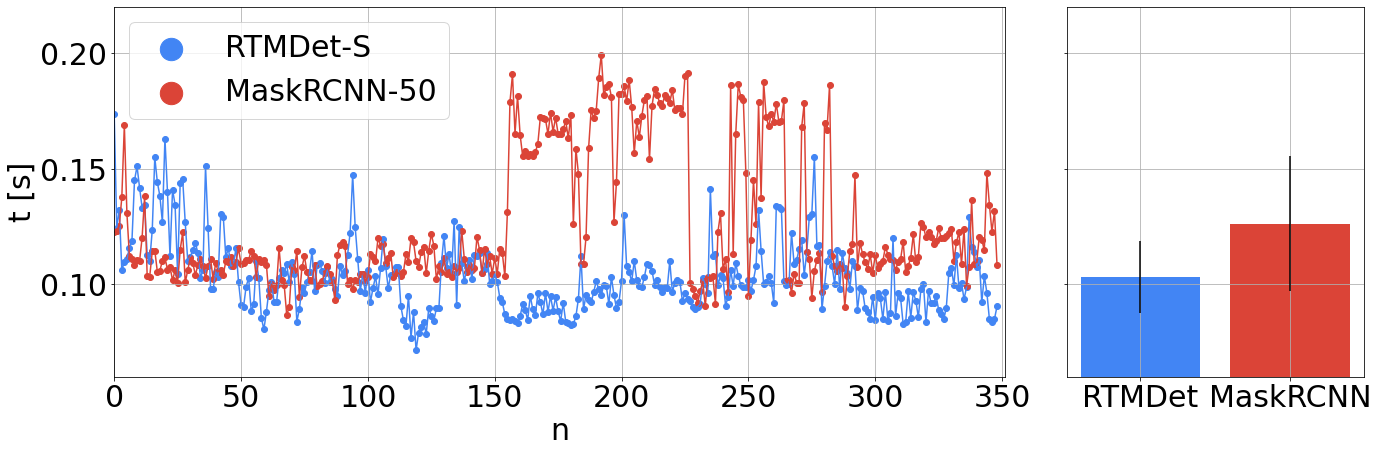

In [158]:
gblue = (66/255,133/255,244/255, 1.0)
gred = (219/255,68/255,55/255, 1.0)

def plot_side_by_side(a, b):
    fig, axs = plt.subplots(1, 2, figsize=(20,7), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
    a = [float(i) for i in a[1:350]]
    b = [float(i) for i in b[1:350]]
    # Plotting the first graph (line graph)
    plt.rcParams.update({'legend.handlelength':2, 
                         'legend.fontsize': 30, 
                         'font.size': 30})  
    axs[0].scatter(list(range(0, len(a))), a, label='RTMDet-S', color= gblue)
    axs[0].plot(list(range(0, len(a))), a, color=  gblue  )  
    axs[0].scatter(list(range(0, len(b))), b, label='MaskRCNN-50', color=gred )
    axs[0].plot(list(range(0, len(b))), b,  color=gred )
    axs[0].set_xlabel('n')
    axs[0].set_ylabel('t [s]')
    axs[0].set_xlim([0, 351])
    axs[0].set_ylim([0.06, 0.22])
    axs[0].grid()
    
    # Set custom size of the legend handle
    lgnd = axs[0].legend(loc="upper left", scatterpoints=1, fontsize=30)
    for handle in lgnd.legendHandles:
        handle.set_sizes([500.0])
    
    avg_t = [np.sum(a)/len(a), np.sum(b)/len(b)]
    yerr_ = [np.std(a), np.std(b)]

    # Plotting the second graph (bar chart with standard deviation)
    axs[1].bar(['RTMDet', 'MaskRCNN'], avg_t, yerr=yerr_, color=[gblue, gred])
    #axs[1].set_xlabel('Models')
    #axs[1].set_ylabel('Average inference time [t]')
    axs[1].grid()

    # Show the plots
    plt.tight_layout()
    plt.show()
    fig.savefig("./inference_speed.pdf")

plot_side_by_side(rtmdet, maskrcnn)

## Colors
Blue. PANTONE: PMS 660 C. Hex Color: #4285F4; RGB: (66,133,244) CMYK: (88,50,0,0)
Red. PANTONE: PMS 7619 C. Hex Color: #DB4437; RGB: (219,68,55) CMYK: (0,78,85,12)
Yellow. PANTONE: PMS 123 C. Hex Color: #F4B400; RGB: (244,160,0) CMYK: (0,20,90,0)
Green. PANTONE: PMS 7724 C. Hex Color: #0F9D58; RGB: (15,157,88)